# Transfer Learning with Tensorflow : Scaling up

In [1]:
# Install TensorFlow 2.9.0 to avoid issues (later versions may work)
# -U stands for "update" and "-q" stands for "quiet"
import tensorflow as tf
if tf.__version__ != "2.9.0":
  !pip install -U -q tensorflow==2.9.0
  !pip install -q tensorflow_datasets==4.8.2
  !pip install -q protobuf==3.19.6
  !pip install -q tensorflow_metadata==1.12.0
  # import os
  # os._exit(00)
print(tf.__version__)

2.9.0


In [4]:
# import helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import os
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2023-07-04 02:54:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-04 02:54:48 (64.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
os.listdir("/")

['boot',
 'lib64',
 'lib',
 'bin',
 'home',
 'dev',
 'sbin',
 'run',
 'mnt',
 'root',
 'tmp',
 'proc',
 'libx32',
 'srv',
 'opt',
 'media',
 'etc',
 'sys',
 'usr',
 'lib32',
 'var',
 'content',
 '.dockerenv',
 'datalab',
 'tools',
 'python-apt',
 'NGC-DL-CONTAINER-LICENSE']

In [6]:
# Download Food101 data -> 10% data
import os
if "101_food_classes_10_percent.zip" not in os.listdir("/"):
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-07-04 02:54:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.1MB/s    in 68s     

2023-07-04 02:56:02 (22.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_cl

In [8]:
# Set up data inputs
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=(224,224),
                                                                 batch_size=32,
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224,224),
                                                                batch_size=32,
                                                                shuffle=False)  #Dont shuffle for prediction and analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning with 10% of Food101 data
* Create ModelCheckpoint callback
* Create a data augmentation layer
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model
* Compile model
* Feature extract for 5 epochs

In [9]:
# Create callback:
checkpoint_path = "101_food_checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         safe_freq="epoch",
                                                         monitor="accuracy")

In [10]:
# Create data augmentation layer:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
],name="data_augmentation")

In [11]:
#Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=(224,224,3))
x = data_augmentation(inputs,training=True)
x = base_model(x,training=False) # weights which need to stay frozen will stay frozen -> Inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names),activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [12]:
# GEt summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
#Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#Run feature extraction for 5 epochs
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 126s 464ms/step - loss: 3.3760 - accuracy: 0.2659 - val_loss: 2.6157 - val_accuracy: 0.4052
Epoch 2/5
237/237 [==============================] - 89s 372ms/step - loss: 2.2048 - accuracy: 0.4902 - val_loss: 2.1931 - val_accuracy: 0.4701
Epoch 3/5
237/237 [==============================] - 79s 331ms/step - loss: 1.8190 - accuracy: 0.5716 - val_loss: 2.0512 - val_accuracy: 0.4878
Epoch 4/5
237/237 [==============================] - 70s 296ms/step - loss: 1.6067 - accuracy: 0.6133 - val_loss: 1.9876 - val_accuracy: 0.4968
Epoch 5/5
237/237 [==============================] - 68s 284ms/step - loss: 1.4698 - accuracy: 0.6382 - val_loss: 1.9232 - val_accuracy: 0.5005


In [14]:
# Evaluate on full data
result = model.evaluate(test_data)
result

790/790 [==============================] - 143s 180ms/step - loss: 1.7773 - accuracy: 0.5415


[1.7772513628005981, 0.5414653420448303]

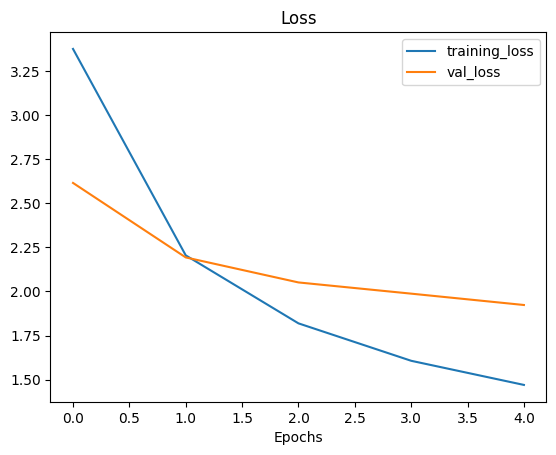

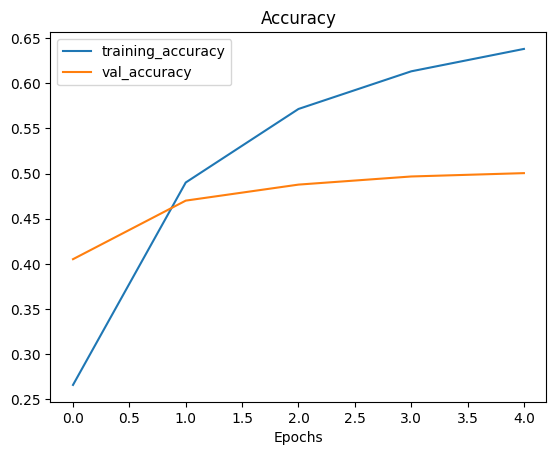

In [15]:
plot_loss_curves(history)

In [16]:
#Fine tune
base_model.trainable=True

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [17]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
history1=model.fit(train_data,
                   epochs=10,
                   validation_data=test_data,
                   validation_steps=int(0.15*len(test_data)),
                   steps_per_epoch=len(train_data),
                   initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 73s 262ms/step - loss: 1.2144 - accuracy: 0.6867 - val_loss: 1.9015 - val_accuracy: 0.5101
Epoch 6/10
237/237 [==============================] - 62s 259ms/step - loss: 1.1012 - accuracy: 0.7085 - val_loss: 1.9185 - val_accuracy: 0.5079
Epoch 7/10
237/237 [==============================] - 58s 243ms/step - loss: 1.0211 - accuracy: 0.7234 - val_loss: 1.9133 - val_accuracy: 0.5058
Epoch 8/10
237/237 [==============================] - 56s 236ms/step - loss: 0.9491 - accuracy: 0.7457 - val_loss: 1.9198 - val_accuracy: 0.5167
Epoch 9/10
237/237 [==============================] - 55s 228ms/step - loss: 0.8843 - accuracy: 0.7658 - val_loss: 1.9153 - val_accuracy: 0.5196
Epoch 10/10
237/237 [==============================] - 52s 220ms/step - loss: 0.8383 - accuracy: 0.7753 - val_loss: 1.9382 - val_accuracy: 0.5103


In [18]:
# Evaluate
result1 = model.evaluate(test_data)
result1

790/790 [==============================] - 122s 154ms/step - loss: 1.6535 - accuracy: 0.5740


[1.653538703918457, 0.5740197896957397]

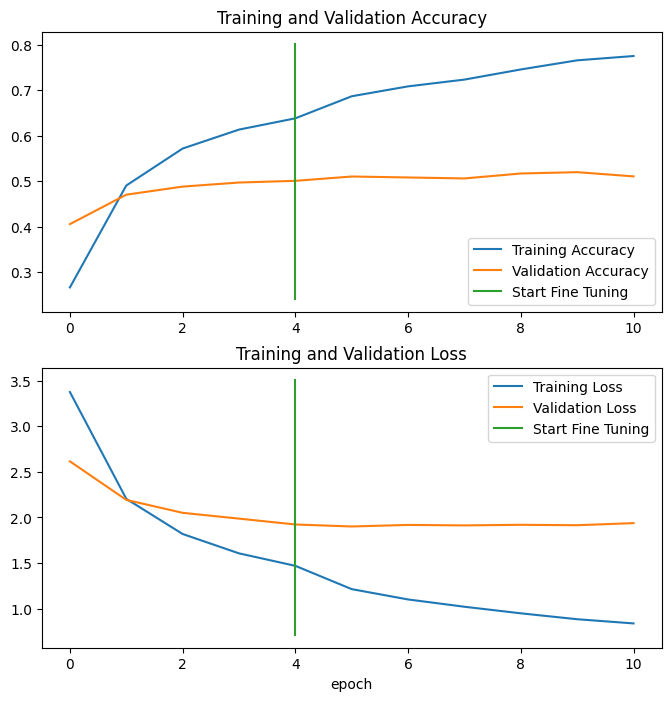

In [19]:
compare_historys(history,history1)

The model is overfitting even after fine tuning

In [20]:
# Saving and loading our model -> to use our model for external applications
model.save("tensorflow_course/101_food_classes_10_percent_model")

In [21]:
#Load the entire model
loaded_model = tf.keras.models.load_model("tensorflow_course/101_food_classes_10_percent_model")

In [22]:
# Evaluate the loaded model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 121s 149ms/step - loss: 1.6539 - accuracy: 0.5733


[1.6538677215576172, 0.5733069181442261]

In [23]:
result1

[1.653538703918457, 0.5740197896957397]

### Evaluating the performance of the model across all different classes

In [24]:
## Download the pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-07-04 03:19:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  12.5MB/s    in 3.6s    

2023-07-04 03:19:52 (12.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [25]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [26]:
#Load in the downloaded model
model_1 = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")
model_1.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________

In [27]:
# Evaluate the loaded model
results = model_1.evaluate(test_data)
results

790/790 [==============================] - 79s 96ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [28]:
## Make predictions with trained model
preds_probs = model_1.predict(test_data,verbose=1)

790/790 [==============================] - 78s 96ms/step


In [29]:
len(preds_probs)

25250

In [30]:
preds_probs.shape

(25250, 101)

In [31]:
len(test_data)

790

In [32]:
# Let us see first 10 predictions
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [33]:
# First predicition
preds_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [34]:
len(preds_probs[0])

101

In [35]:
# We get one pred prob per class
print("Number of prediction probabilities for first sample :",len(preds_probs[0]))
print("What prediciton probability of first sample looks like :\n",preds_probs[0])
print("The class with the highest prediction probabilty by the model for first sample :",tf.argmax(preds_probs[0]).numpy())

Number of prediction probabilities for first sample : 101
What prediciton probability of first sample looks like :
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05

In [36]:
test_data.class_names[52]

'gyoza'

In [37]:
# Get pred classes of each label
pred_classes = tf.argmax(preds_probs,axis=1).numpy()
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [38]:
len(pred_classes)

25250

In [39]:
# Compare the predictions with actual class
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [40]:
# To get test_labels -> unravel test_data
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
len(y_labels)

25250

we kept shuffle=False in beginning, hence the order in preds_prods and y_labels are in same order, so comparining them is easier now

In [42]:
# Let us try scikin learn accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

In [43]:
results

[1.8027204275131226, 0.6077623963356018]

In [44]:
import numpy as np
np.isclose(results[1],sklearn_accuracy)

True

### Making confusion matrix

In [45]:
from helper_functions import make_confusion_matrix

In [46]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      classes=test_data.class_names,
                      figsize=(120,120),
                      text_size=40)

Output hidden; open in https://colab.research.google.com to view.

### Classification report
for each class

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,
                            pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of the model's predictions but with so may classes, they are quite hard to understand
* Create visulization for better understanding


In [48]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_labels,
                                                   pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

let's plot f1 scores of classes

In [49]:
class_f1_scores={}
for key,val in classification_report_dict.items():
  if key=="accuracy":
    break
  else:
    class_f1_scores[test_data.class_names[int(key)]] = val["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [50]:
# Turn f1 scores in dataframes
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [51]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [52]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

In [53]:
f1_scores[:-10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
5            beet_salad  0.418605
87             scallops  0.397541
37         filet_mignon  0.387006
8         bread_pudding  0.386694
98             tiramisu  0.385882

[91 rows x 2 columns]

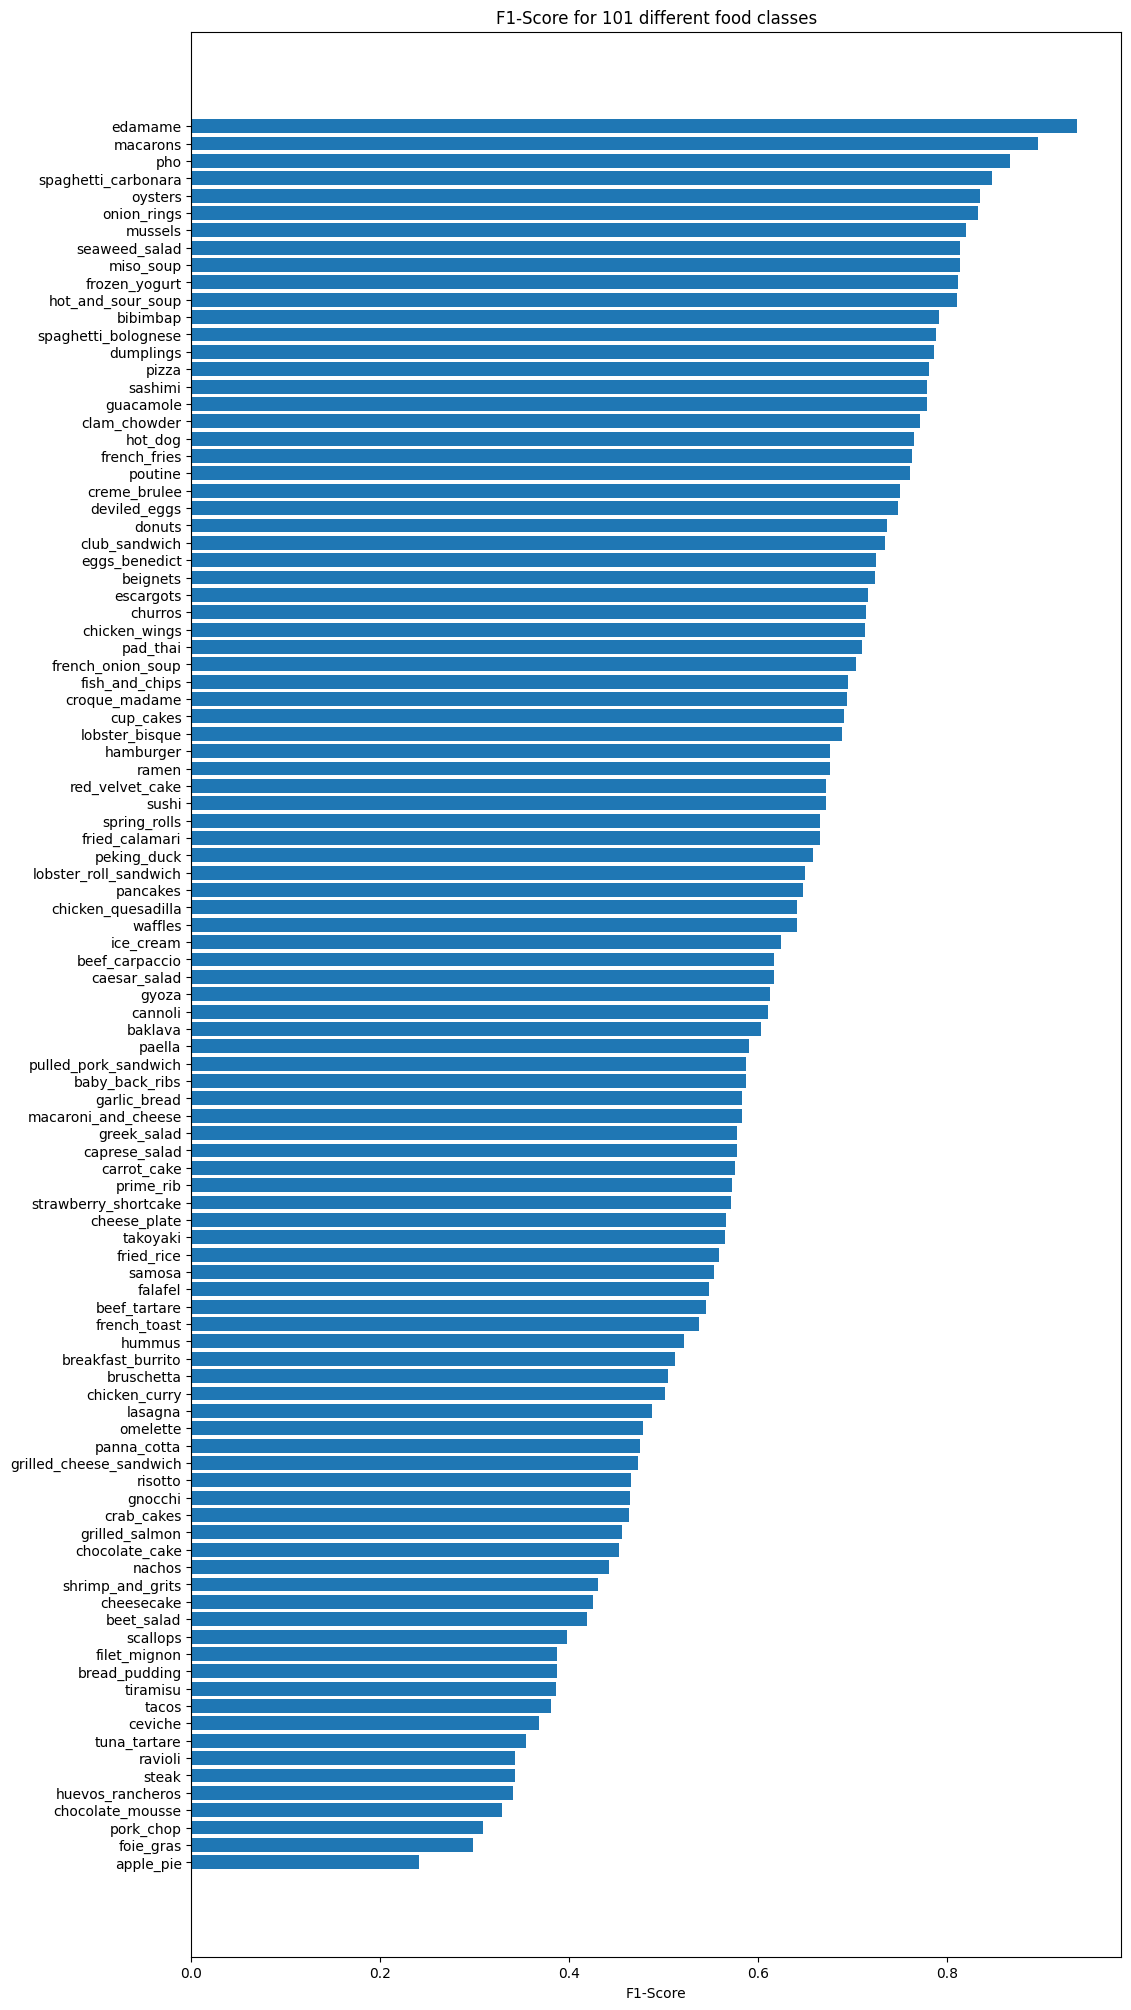

In [54]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Score for 101 different food classes")
ax.invert_yaxis()
plt.show()

### Visualise predictions on test images

Functions to load and preprocess the loaded image and use custom image
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor
* Scale the image to get all the pixel values between 0 and 1 (if necessary)

In [55]:
# Create a function to lead and prepare images
def load_and_prep(filename,img_shape=224,scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 [==============================] - 0s 311ms/step


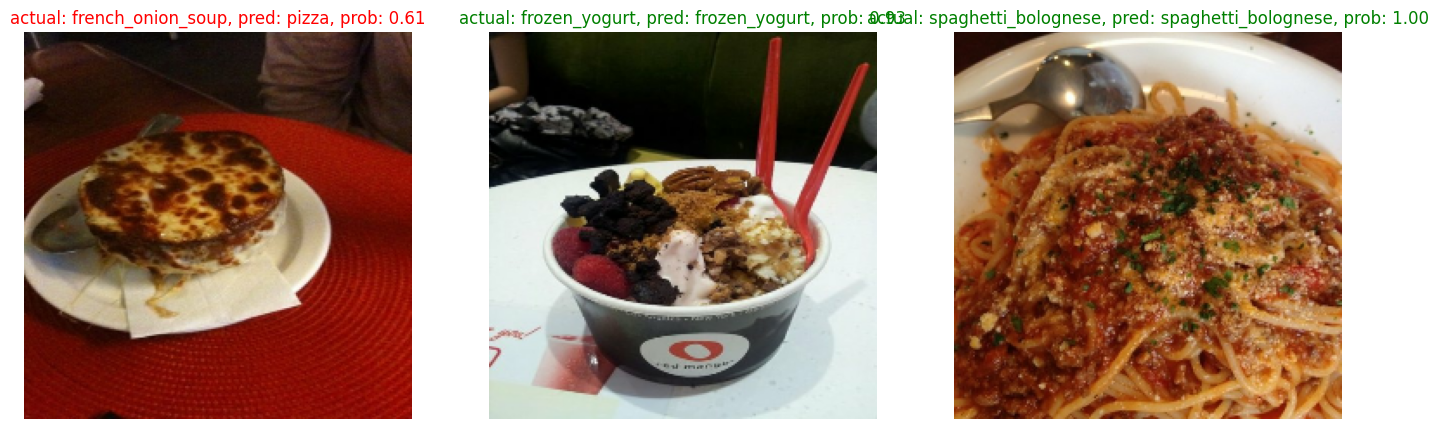

In [56]:
# Make preds on series of random images
import os
import random

class_names=test_data.class_names

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong prediction

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction

In [57]:
# Get all image file paths in test dataset
filepaths=[]
for x in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(x.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [58]:
# Create dataframe
import pandas as pd
df = pd.DataFrame({"img_path":filepaths,
                   "y_true":y_labels,
                   "y_pred":pred_classes,
                   "pred_confidence":preds_probs.max(axis=1),
                   "y_true_classname":[class_names[i] for i in y_labels],
                   "y_pred_classname":[class_names[i] for i in pred_classes]})
df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_confidence y_true_classname      y_pred_classname  
0             0.847418        apple_pie                 gyoza  
1             0.964017        apple_pie             apple_pie  
2             0.959259        apple_pie             apple_pie  
3             0.658607        apple_pie  pulled_pork_sandwich  
4             0.367901        apple_pie             prime_rib  
...                ...              ...                   ...  
25245         0.972823          waffles               waffles  
25246         0.878028          waffles          cheese_plate  
25247         0.537899          waffles               waffles  
25248         0.501949          waffles  strawberry_shortcake  
25249         0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [59]:
df["pred_correct"] = df["y_true"]==df["y_pred"]
df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_confidence y_true_classname      y_pred_classname  pred_correct  
0         0.847418        apple_pie                 gyoza         False  
1         0.964017        apple_pie             apple_pie          True  
2         0.959259        apple_pie             apple_pie          True  
3         0.658607        apple_pie  pulled_pork_sandwich         False  
4         0.367901        apple_pie             prime_rib         False

In [60]:
# SOrt to have most wrong on top
top_wrong = df[df["pred_correct"]==False].sort_values("pred_confidence",ascending=False)[:100]

In [61]:
top_wrong

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent/test/escargots/1...      35      41   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
7924   b'101_food_classes_10_percent/test/donuts/3454...      31      29   
18586  b'101_food_classes_10_percent/test/peking_duck...      74      39   
3519   b'101_food_classes_10_percent/test/carrot_cake...      14      21   

       pred_confidence       y_true_classname       y_pred_classname  \
21810         0.999997               scallops              cup_cakes   
231           0.999995              apple_pie                waffles   
15359         0.999988  lobster_roll_sandwich              hamburger   
23539         0.999987   strawberry_shortcake        red_velvet_cake   
21400         0.999981                 samosa           spring_rolls   
...                ...                    ...                    ...   
8763          0.997169              escargots      french_onion_soup   
2663          0.997055             bruschetta  lobster_roll_sandwich   
7924          0.997020                 donuts              cup_cakes   
18586         0.996885            peking_duck              foie_gras   
3519          0.996842            carrot_cake         chocolate_cake   

       pred_correct  
21810         False  
231           False  
15359         False  
23539         False  
21400         False  
...             ...  
8763          False  
2663          False  
7924          False  
18586         False  
3519          False  

[100 rows x 7 columns]

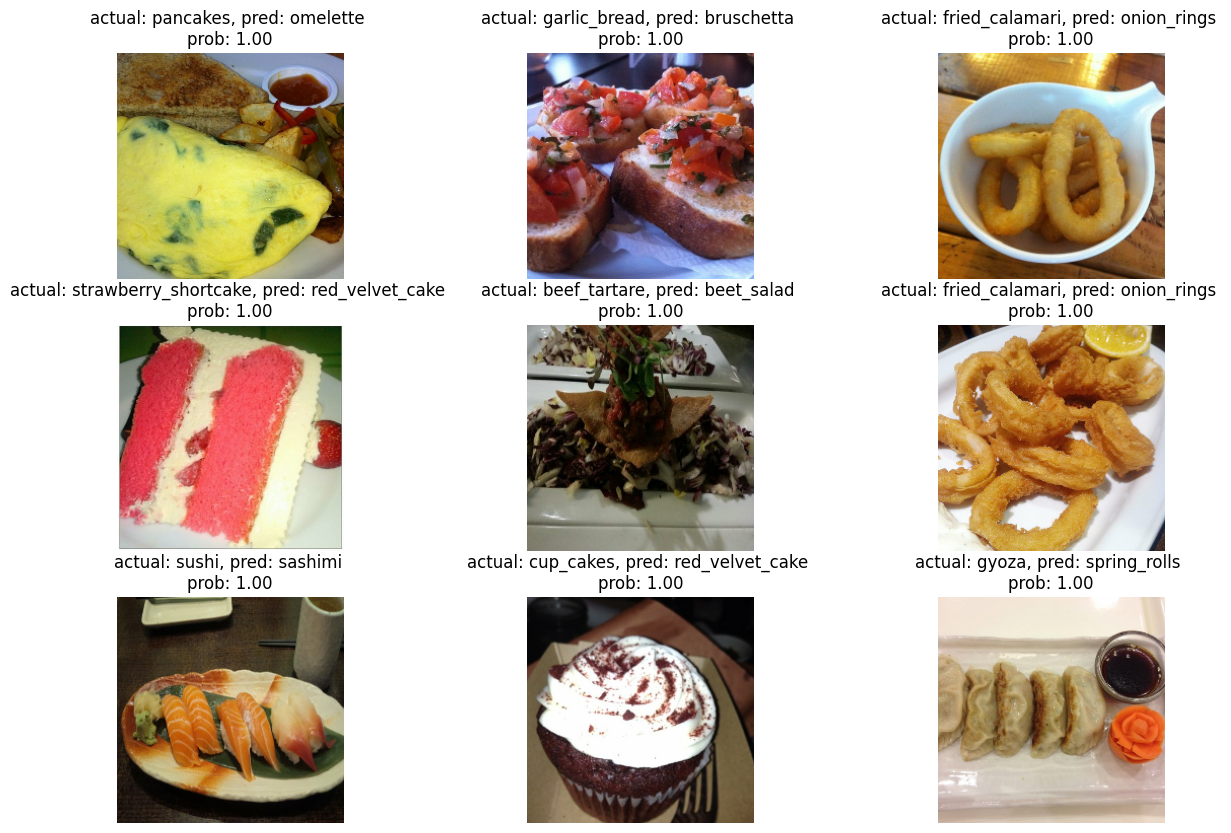

In [62]:
# Visualise
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

### Test out on custom images

In [63]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2023-07-04 03:25:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 142.251.175.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.70MB/s    in 1.6s    

2023-07-04 03:25:16 (7.70 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [64]:
unzip_data("custom_food_images.zip")

In [65]:
os.listdir("custom_food_images")

['steak.jpeg',
 'ramen.jpeg',
 'chicken_wings.jpeg',
 'hamburger.jpeg',
 'pizza-dad.jpeg',
 'sushi.jpeg']

In [66]:
images = ["custom_food_images/"+i for i in os.listdir("custom_food_images")]
images

['custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 253ms/step


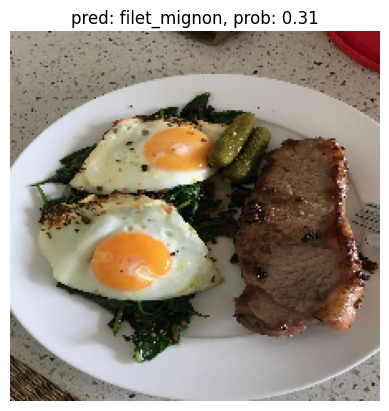

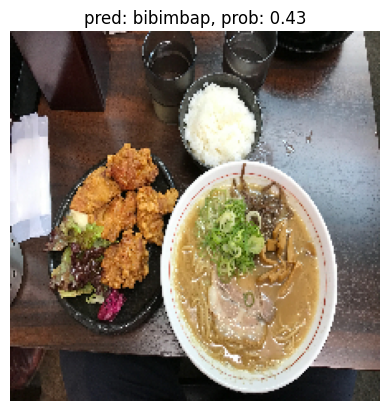

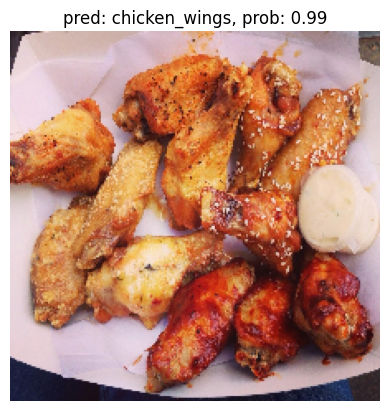

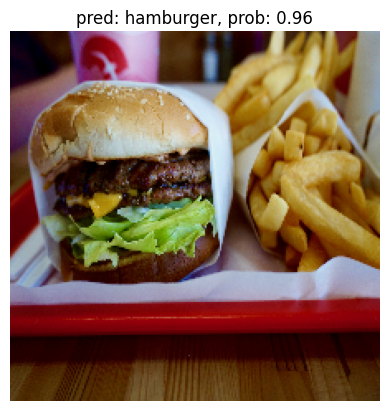

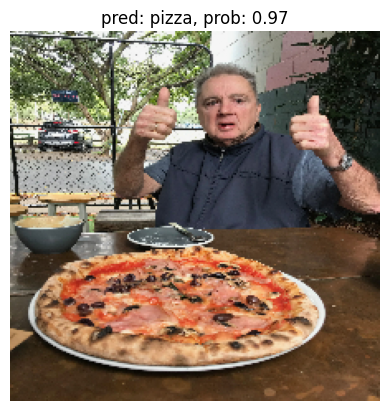

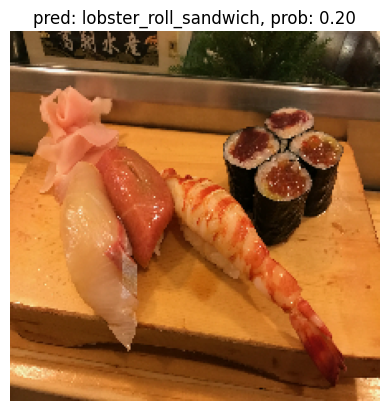

In [67]:
# Make predictions on images
for img in images:
  img = load_and_prep(img,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Exercise:
1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate the first model (the feature extraction model) with mixed_precision turned on.
  * Does it make the model train faster?
  * Does it effect the accuracy or performance of our model?
  * What's the advantages of using mixed_precision training?

['/content/nachos.jpg', '/content/ice_cream.jpg', '/content/garlic_bread.jpg', '/content/fried_rice.jpg']
1/1 [==============================] - 0s 36ms/step


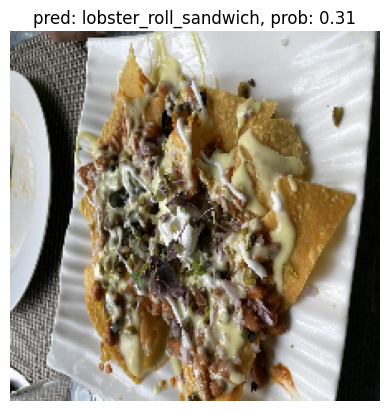

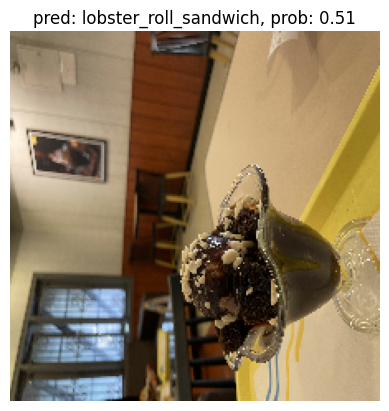

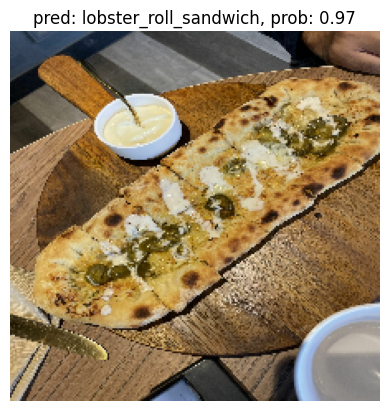

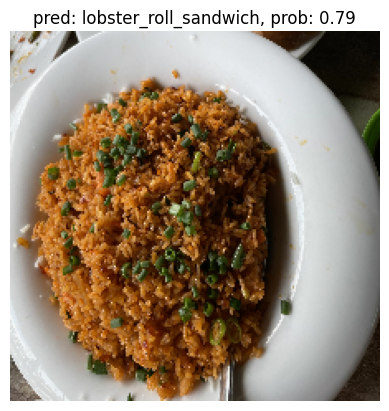

In [74]:
# 1. Take your own photos of food and use the trained model to make predictions on them
images=[]
for i in os.listdir("/content/"):
  if ".jpg" in i:
    images.append("/content/"+i)
print(images)
for img in images:
  img = load_and_prep(img,scale=False)
  pred_prob = model_1.predict(tf.expand_dims(img,axis=0))
  class_pred = class_names[tf.argmax(pred_prob[0])]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [75]:
# 2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
## Feature extraction for 10 epochs
print("Feature extraction (10)")
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101,activation=tf.keras.activations.softmax)(x)
model_feature_extraction = tf.keras.Model(inputs,outputs)
model_feature_extraction.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['accuracy'])
history_feature_extraction = model_feature_extraction.fit(train_data,
                                                          epochs=10,
                                                          steps_per_epoch=len(train_data),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          verbose=1)

print("Feature extraction plus fine tuning (5+5)")
## Feature extraction plus fine tuning
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101,activation=tf.keras.activations.softmax)(x)
model_feature_extraction_plus_fine = tf.keras.Model(inputs,outputs)
model_feature_extraction_plus_fine.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['accuracy'])
history_feature_extraction_plus_fine = model_feature_extraction_plus_fine.fit(train_data,
                                                                              epochs=5,
                                                                              steps_per_epoch=len(train_data),
                                                                              validation_data=test_data,
                                                                              validation_steps=int(0.15*len(test_data)),
                                                                              verbose=1)
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
model_feature_extraction_plus_fine.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                 metrics=['accuracy'])
history_feature_extraction_plus_fine = model_feature_extraction_plus_fine.fit(train_data,
                                                                              epochs=10,
                                                                              steps_per_epoch=len(train_data),
                                                                              validation_data=test_data,
                                                                              validation_steps=int(0.15*len(test_data)),
                                                                              verbose=1,
                                                                              initial_epoch=history_feature_extraction_plus_fine.epoch[-1])

x1 = (model_feature_extraction.evaluate(test_data))
x2 = model_feature_extraction_plus_fine.evaluate(test_data)
if x1[1]>x2[1]:
  print("Model with only feature extraction is better than fine tuning")
else:
  print("Model with both feature extraction and fine tuning performs better than just feature extraction")

Feature extraction (10)
Epoch 1/10
237/237 [==============================] - 42s 148ms/step - loss: 3.1081 - accuracy: 0.3333 - val_loss: 2.2236 - val_accuracy: 0.4979
Epoch 2/10
237/237 [==============================] - 34s 143ms/step - loss: 1.8289 - accuracy: 0.5834 - val_loss: 1.8014 - val_accuracy: 0.5591
Epoch 3/10
237/237 [==============================] - 34s 142ms/step - loss: 1.4302 - accuracy: 0.6651 - val_loss: 1.6902 - val_accuracy: 0.5678
Epoch 4/10
237/237 [==============================] - 34s 143ms/step - loss: 1.2025 - accuracy: 0.7225 - val_loss: 1.6455 - val_accuracy: 0.5742
Epoch 5/10
237/237 [==============================] - 34s 143ms/step - loss: 1.0418 - accuracy: 0.7595 - val_loss: 1.5864 - val_accuracy: 0.5834
Epoch 6/10
237/237 [==============================] - 35s 144ms/step - loss: 0.9099 - accuracy: 0.8011 - val_loss: 1.5532 - val_accuracy: 0.5919
Epoch 7/10
237/237 [==============================] - 33s 137ms/step - loss: 0.8001 - accuracy: 0.8283 - v

In [76]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1d9d7d2b-991c-7d01-38bb-793d2215ffb1)


In [77]:
# 3. Recreate the first model (the feature extraction model) with mixed_precision turned on.
from tensorflow import keras
from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)
#print('Compute dtype: %s' % policy.compute_dtype)
#print('Variable dtype: %s' % policy.variable_dtype)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
# x = tf.keras.layers.Dense(40,activation=tf.keras.activations.relu)(inputs)
# x = tf.keras.layers.Conv2D(filters=25,kernel_size=3,activation=tf.keras.activations.relu)(x)
# x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101,activation=tf.keras.activations.softmax,dtype=tf.float32)(x)
# outputs=tf.keras.layers.Activation('softmax', dtype='float32')(x)
model_feature_extraction = tf.keras.Model(inputs,outputs)
model_feature_extraction.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['accuracy'])
history_feature_extraction = model_feature_extraction.fit(train_data,
                                                          epochs=10,
                                                          steps_per_epoch=len(train_data),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          verbose=1)

Epoch 1/10
237/237 [==============================] - 39s 134ms/step - loss: 3.1263 - accuracy: 0.3323 - val_loss: 2.2167 - val_accuracy: 0.5156
Epoch 2/10
237/237 [==============================] - 33s 138ms/step - loss: 1.8325 - accuracy: 0.5803 - val_loss: 1.8549 - val_accuracy: 0.5482
Epoch 3/10
237/237 [==============================] - 32s 133ms/step - loss: 1.4291 - accuracy: 0.6652 - val_loss: 1.7035 - val_accuracy: 0.5673
Epoch 4/10
237/237 [==============================] - 35s 145ms/step - loss: 1.2004 - accuracy: 0.7241 - val_loss: 1.6144 - val_accuracy: 0.5813
Epoch 5/10
237/237 [==============================] - 34s 143ms/step - loss: 1.0312 - accuracy: 0.7661 - val_loss: 1.5900 - val_accuracy: 0.5842
Epoch 6/10
237/237 [==============================] - 34s 143ms/step - loss: 0.9078 - accuracy: 0.7980 - val_loss: 1.5756 - val_accuracy: 0.5869
Epoch 7/10
237/237 [==============================] - 34s 142ms/step - loss: 0.7997 - accuracy: 0.8301 - val_loss: 1.5679 - val_ac

* The training time for each epoch is faster when using mixed precision
* The performance has taken a hit
* Advantages of using mixed precison is that the training time is faster on Nvidia GPU's, it uses lesser number of bits to perform calculation while maintaining full length of bits for varibales